# Finite Volume Method for the Advection Equation 1D



## Conservation Laws

Let us consider the following partial differential equation
\begin{equation}
\tag{1}
u_t(x,t) + \beta\cdot u_x(x,t) = 0, \quad (x,t)\in\Omega\times (0,T),
\end{equation}
where $\Omega=(a,b)\subset\mathbb R$ and  $\beta\in\mathbb R$.

- It is a hyperbolic equation which represents a **conservation law**. In fact, it can be written as
\begin{equation}
\tag{2}
u_t(x,t) + f( u(x,t) )_x = 0
\end{equation}
for the flux $f(q)=\beta\cdot u(x,t)$ and one has:
$$
\frac d{dt} \int_{x_1}^{x_2} u(x,t)\; dt = f(u(x_1,t)) - f(u(x_2,t)),
$$
for all $x_1,x_2\in(a,b)$. 

- That is: the mass (total ammount of $u$) in any subinterval $(x_1,x_2)$ is conserved, and it only can change due to the flux through the endpoints $x_1$ and $x_2$.

## Finite Volume Methods

**Finite volume** are numerical methods for approximating the solution of (1) which preserve the former conservation property.

They are defined in a partition of $\Omega$, in this case a set of *grid cells* or "finite volumes",
$$
C_i = (x_{i-1/2},x_{i+1/2}), \quad i=1,...,N_x,
$$
whose extreme points, 
$$x_{1/2}<x_{1+1/2}\dots<x_{n+1/2},$$
are in $(a,b)$. 

For simplicity, we will assume a uniform grid, i.e $\Delta x=x_{i+1/2}-x_{i-1/2}$ (length of grids) is constant.

Our unknowns will be the **averages of $u$ in each cell**. So let us compute the average of (2) in each $C_i$:
$$
\frac 1{\Delta x} \int_{C_i} u_t(x,t)\; dx = 
\frac {-1}{\Delta x} \int_{C_i} f(u(x,t))_x \; dx,
$$
that is
$$
\frac d{dt} \frac 1{\Delta x} \int_{C_i} u(x,t)\; dx = 
\frac {-1}{\Delta x} \big[ f(u(x_{i+1/2},t))  - f(u(x_{i-1/2},t)) \big].
$$

Now we take a uniform time partition, 
$$
0=t_0<t_1<\cdots <t_{N_t}=T, 
\quad \text{with } \Delta t=t_{n+1}-t_n,
$$ 
and integrate in each time interval $[t_n,t_{n+1}]$:
\begin{equation}
\tag{3}
\frac 1{\Delta x}  \int_{C_i} u(x,t_{n+1})\; dx 
- \frac 1{\Delta x}  \int_{C_i} u(x,t_{n})\; dx 
= 
\frac {-1}{\Delta x} \Big[ \int_{t_n}^{t_{n+1}}f(u(x_{i+1/2},t)) \; dt  - \int_{t_n}^{t_{n+1}}f(u(x_{i-1/2},t)) \; dt  \Big].
\end{equation}

We want to obtain approximations to the integrals on the left hand side:
$$
u_i^n \simeq \frac {1}{\Delta x} \int_{C_i} u(x,t_{n})\; dx.
$$ 
For that, we have to approximate also (in terms of $u_i^n$) the right hand side integrals. That is, we must **manage how to smartly approximate the average fluxes** in $[t_n,t_{n+1}]$: 
$$
F_{i-1/2}^n \simeq \frac {1}{\Delta t}  \int_{t_n}^{t_{n+1}}f(u(x_{i-1/2},t)) \; dt.
$$
Usually 
$$
F_{i-1/2}^n = {\cal F}(u_i^n, u_{i+1}^{n})
$$
where ${\cal F}$ is some adequate *numerical flux function*.

If we manage how to do it, equation (3) can be approximated by the following **explicit finite volume method** :
\begin{equation}
\tag{4}
u_i^{n+1} = u_i^n -  \frac{\Delta t}{\Delta x} \left[ F_{i+1/2}^n -  F_{i-1/2}^n \right] 
\end{equation}

## Upwind Method for the Advection Equation

Let us return to the 1D  Transport Equation:
\begin{equation*}
u_t(x,t) + \beta\cdot u_x(x,t) = 0.
\end{equation*}

Assuming $\beta>0$, we define the numerical flux:
$$
F_{i-1/2}^n = {\cal F}(u_i^n, u_{i+1}^{n+1}) = \beta u^n_{i-1}.
$$
That is, for each cell we approximate the flux by the solution at the left endpoint of the cell.

Then, the finite volume method (4) reads:
$$
u_i^{n+1} = u_i^n -  \frac{\beta \Delta t}{\Delta x} \left[ u_{i}^n -  u_{i-1}^n \right] 
$$

It can be proven stability if $\Delta t$ is small enough. Specifically if the following CFL condition holds:
$$
0 < \frac{\beta\Delta t}{\Delta x} \le 1.
$$


## Excercise:
1. Program a function `advection1D_Upwind_FVM` with the following parameters:
       a, b : [a,b] interval
       beta : advection velocity
       u0: array of initial values [u_1^0, u_2^0..., u_{N}^0]
       dx, dt:  x step and t stp
       nt: number of time iterations

   - It returns a list, `solution`, such that `solution[i]` is the approximation at time iteration `i`
    
   - Use **periodic boundary condtions**, $u(a)=u(b)$.
    
2. Define the functions `positive(f)` and `negative(f)`, which compute the positive and negative part of a function (i.e., max(f,0) and min(f,0), respectively). Extend the function to admit positive and negative values of $\beta$, using the following numerical flux:
$$
F_{i-1/2}^n = {\cal F}(u_i^n, u_{i+1}^{n+1}) = 
\texttt{positive}(\beta) u^n_{i-1} +
\texttt{negative}(\beta) u^n_{i}
$$

## Solution of part 1

In [1]:
import numpy as np
import matplotlib.pylab as mpl

In [2]:
def advection1D_Upwind_FVM(a, b, beta, u0, dx, dt, nt, verbosity=False):
    """
    1D Transport Equation: Upwind Finite Volume method
    
    Periodic boundary conditions are assumed: 
       u_1^n = u_{N_x}^n for all time step, n.
    
    a, b : [a,b] interval
    beta : advection velocity
    u0: array of initial values [u_1^0, u_2^0..., u_{N}^0]
    dx, dt:  x step and t stp
    nt: number of time iterations
    
    The function returns a list of
    """
    nx = len(u0)
    solution=[u0] # List of solutions at each time stepç
    
    # For boundary conditions, we will add two ghost cells to the solution,
    # u[0] and u[nx+1] (while u[1],...,u[nx] are actual unknowns)
    # Here we apply periodic b.c.    
    u0 = np.concatenate( ([u0[-1]], u0, [u0[0]]) ) 

    u = np.empty(nx+2)
    r = beta*dt/dx
     
    # assert r<1  # If CFL is not verified, throw exception AssertionError
    for n in range(nt):
        if verbosity:
            print(f"Time iteration {n}")
            print(u0)
            
        #u[1:nx] = u0[1:nx] - r*(u[1:nx] - u[0:nx-1])
        for i in range(1,nx+1): # 1,...,nx
            u[i] = u0[i] - r*(u0[i]-u0[i-1]) 
            
        # Save data and prepare next iteration
        u0[0]=u[nx]; 
        u0[1:nx+1] = u[1:nx+1]
        u0[-1]=u[1]
        
        solution.append( u[1:nx+1].copy() )
        
    return solution

n = 0


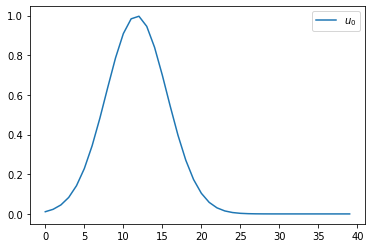

n = 5


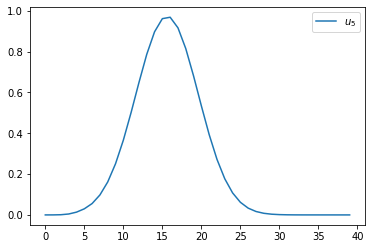

n = 10


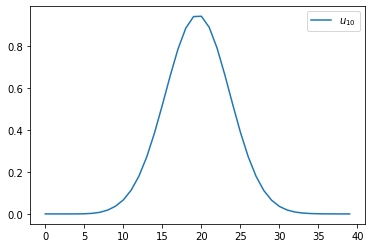

n = 15


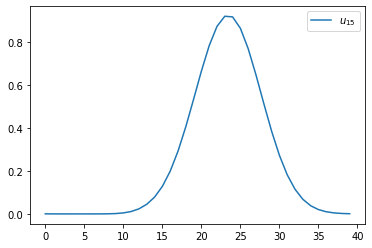

n = 20


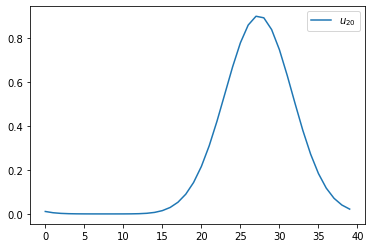

n = 25


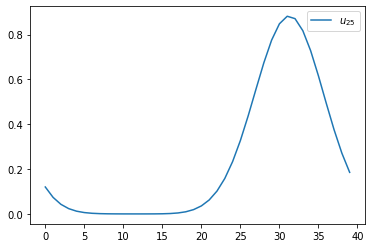

n = 30


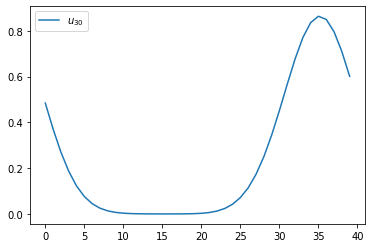

n = 35


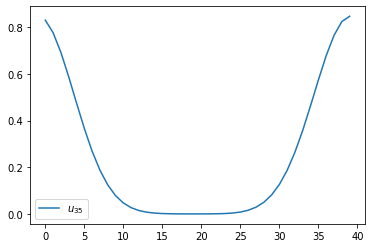

n = 40


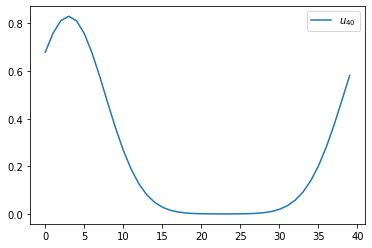

n = 45


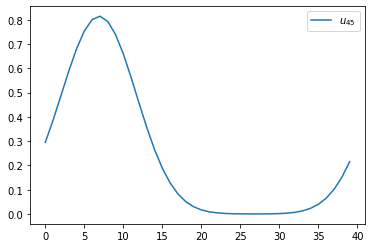

In [3]:
# Data
a, b = 0, 1
nx=40
x_i = np.linspace(a,b,nx)
def q0(x): return np.exp(-50*(x-0.3)**2)

# Test
nt = 50
U = advection1D_Upwind_FVM (a,b, beta=1, 
                            u0=q0(x_i), 
                            dx=x_i[1]-x_i[0], dt=0.02, nt=nt,
                            verbosity=False
                           )
import time
for n in range(0,nt,nt//10):
    print("n =", n)
    mpl.plot(U[n], label=f"$u_{{{n}}}$")
    mpl.legend()
    mpl.show()

## Animation

In [10]:
# Import widgets from ipywidgets
from ipywidgets import interact_manual
import ipywidgets as widgets

# Matplotlib includes a function "animation"
from matplotlib import animation, rc

# And in Jupyter we can draw HTML
from IPython.display import HTML

# Definition of the animation
a, b = 0, 1

def animacion(beta, nx, nt, dt, C1, C2, C3):
    def q0(x): return (C1 * np.exp(-C2*(x-C3)**2))
    
    x_i = np.linspace(a,b,nx)
    U = advection1D_Upwind_FVM (a,b, beta, 
                            u0=q0(x_i), 
                            dx=x_i[1]-x_i[0], dt = dt, nt=nt,
                            verbosity=False)
    

    # The basis:


    # First set up the figure, the axis, and the plot element we want to animate
    fig, ax = mpl.subplots()
    ax.set_xlim( (a, b) )
    #   ...we use the initial condition to prepare y limits
    y_m = 1.1*min(U[int(nt/2)])
    y_M = 1.1*max(U[int(nt/2)])
    ax.set_ylim( (y_m, y_M) )
    line, = ax.plot([], [], lw=2)
    fig.set_size_inches(18.5, 10.5, forward=True)
    mpl.close(fig)

    # Initialization for each frame (it plots the background):
    def init():
        line.set_data([], [])
        return (line,)

    # Animation function, which is called for each new frame:
    def animate(i):
        y_i = U[i]
        line.set_data(x_i, y_i)
        ax.set_title(f"Etapa de tiempo {i}\n Tiempo {i*dt}")
        return (line,)

    # Compile the animation. Setting blit=True will only re-draw
    # the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=nt, interval=40, 
                                   blit=True, repeat=False)

    # And use JavaScript in HTML to show results
    return HTML(anim.to_jshtml())

nt_widget = widgets.IntSlider(value=50, min=1.0, max=200.0, step=1, description = "Iteraciones")
beta_widget = widgets.FloatSlider(value=1, min=0.0, max=5.0, step=0.01, description = r"$\beta$")
C1_widget = widgets.FloatSlider(value=1, min=-2.0, max=2.0, step=0.1, description = r"$C_1$")
C2_widget = widgets.FloatSlider(value=50, min=-100.0, max=100.0, step=0.1, description = r"$C_2$")
C3_widget = widgets.FloatSlider(value=0.3, min=-2.0, max=2.0, step=0.1, description = r"$C_3$")
nx_widget = widgets.IntSlider(value=50, min=0.0, max=100.0, step=1, description = "Divisiones x")
dt_widget = widgets.FloatSlider(value=0.02, min=0.0, max=1.0, step=0.001, description = "Paso de t")
#a_widget = widgets.FloatSlider(value=0.0, min=0.0, max=0.45, step=0.05, description = "a")
#b_widget = widgets.FloatSlider(value=1.0, min=0.5, max=1.0, step=0.05, description = "b")

widgets.interact_manual.opts['manual_name'] = 'Simular'
interact_manual(animacion, nt = nt_widget, beta = beta_widget, C1 = C1_widget, C2 = C2_widget, C3 = C3_widget,
                nx = nx_widget, dt = dt_widget)

interactive(children=(FloatSlider(value=1.0, description='$\\beta$', max=5.0, step=0.01), IntSlider(value=50, …

<function __main__.animacion(beta, nx, nt, dt, C1, C2, C3)>